## Image partition and color reducing using diffusion maps

Using sparse matrix. 

Still need to down-sampling the image to no more than 10000 pixels. The largest image I compute is the 75*120 down-sampled version of images/view3.jpg, which takes about three minutes.

### 1. Import libraries

In [2]:
%pylab inline
import cv2
from itertools import product
from scipy import sparse
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


### 2. Load image

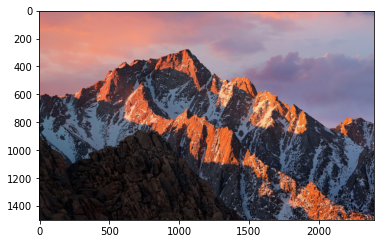

Size of figure:  1500 * 2400


In [5]:
img = cv2.imread('images/view3.jpg')
img = img[:,:,::-1]

#normalize the RGB code
img = img/255

#show image
plt.imshow(img)
plt.show()

#size
print('Size of figure: ', img.shape[0],'*',img.shape[1])

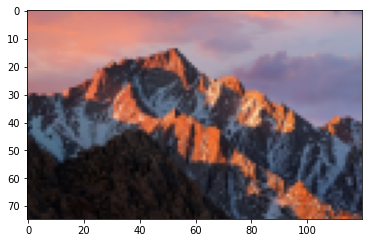

Size of figure:  75 * 120


In [20]:
#create a down-sampled version of image
scale = 20

imc = img[::scale,::scale,:]
imc = zeros(imc.shape)

for i,j in product(range(scale),range(scale)):
    imc += img[i::scale,j::scale,:]
imc = imc/(scale**2)

#show image
plt.imshow(imc)
plt.show()

#size
x, y, z = imc.shape
n = x*y
print('Size of figure: ', x,'*',y)

matplotlib.image.imsave('1.jpg', imc)

### 3. Define Functions

In [9]:
def diffuse(datav):    
    K=getK(datav)           #affinity matrix
    D=getD(K)           
    S, psi=get_eig(D, K)    #eigenvalues and eigenvectors of diffusion matrix
    Y=getY(S, psi)          #diffusion map
    print('Diffusiom map done.')
    
    labels=getlabels(Y)     #cluster data in the diffusion space using K-means
    print('Image partition done.')
    
    return labels

In [15]:
#dist is an n*n symmetric sparse matrix with entries of distance between close datas.
#sigma is an n*n sparse matrix with local scaling parameters on its diagnoal.

def getK(datav):
    lsigma=[]
    ldistptr=[0]
    ldistind=[]
    ldistv=[]

    for i in range(n):
        temp=cdist([datav[i]],datav)
        threshold=sum(temp)/n    #sum(temp)/n, percentile(temp,20)

        ldistv.extend(temp[temp<threshold]**2)
        ldistind.extend(argwhere(temp<threshold)[:,1])
        ldistptr.append(len(ldistind))

        temp.sort()
        if(temp[0,n-s]!=0): lsigma.append(1/temp[0,n-s])
        else: lsigma.append(10000)
            
            
    distptr=array(ldistptr)
    distind=array(ldistind)
    distv=array(ldistv)

    dist=sparse.csr_matrix((distv,distind,distptr),shape=(n,n))    #distance matrix
    sigma=sparse.dia_matrix((lsigma,0), shape=(n,n))               #local scaling
    
    K= -sigma.dot(dist).dot(sigma)
    K.data=exp(K.data)    #affinity matrix
    
    print(1)
    return K

In [11]:
def getD(K):
    return sparse.dia_matrix((1/array(sqrt(sum(K,axis=1)))[:,0], 0), shape=(n,n))

In [16]:
def get_eig(D, K):
    Q = D.dot(K).dot(D)
    
    [U, S, V]=svds(Q, dim)
    
    S=diag(flip(S))
    U=U[:,::-1]
    
    psi=D.dot(U)
    print(3)


    return S, psi

In [13]:
def getY(S, psi):
    return psi.dot(S)

In [14]:
def getlabels(Y):
    kmeans=KMeans(clusters)
    kmeans=kmeans.fit(Y)
    labels=array(kmeans.predict(Y)).reshape(n,1)
    
    return labels

### 5. Calculate labels

In [17]:
clusters=10   #reduce image into how many colors
dim=3         #embedding dimension
s=7           #local scaling parameter

In [18]:
datav=imc.reshape(n, z)
labels=diffuse(datav)

1
3
Diffusiom map done.
Image partition done.


### 6. Display result

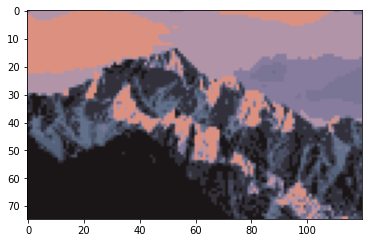

In [21]:
#calculate colors
colorrgb=[]
for i,j in product(range(clusters), range(z)):
    colorrgb.append(percentile( datav[argwhere(labels==i)[:,0],j],50 ))
    
    
#show image
imc=zeros((n,z))
for i in range(clusters): imc[argwhere(labels==i)]=colorrgb[3*i:3*i+3]
imc = imc.reshape(x,y,z)

plt.imshow(imc)
plt.show()
matplotlib.image.imsave('2.jpg', imc)